In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [ ]:
import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EYEIK')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from InputStructures import *
from EyeCatch_implementation import *
from Ground_truth_implementation import *
import json
import numpy as np
import pickle
import os
import pandas as pd

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
def output_motion(hk, ek, micro_saccade, outpath, delay=0.0):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    for i in range(0, len(ek[0])):
        ek[0][i][0] -= delay
    for i in range(0, len(hk[0])):
        hk[0][i][0] -= delay
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pickle.dump(out, f, protocol=2)
    print(outpath)

In [ ]:
import imageio
import numpy as np
from PIL import Image, ImageDraw

def generate_video_multiple_example_concentric_circles(time_arr, angle_arr_1_list, angle_arr_2_list, radius_list, image_size, output_filename='animation.mp4'):
    frames = []
    # any one of them could be the time array
    for i in range(len(time_arr)):
        # set the image to be black        
        img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        img[:, :] = [0, 0, 0]  # Fill the image with black initially
        # Create an image object using PIL
        pil_img = Image.fromarray(img)

        # Calculate the center of the image
        center_x = image_size // 2
        center_y = image_size // 2
        for j in range(len(angle_arr_1_list)):
            angle_arr_1 = angle_arr_1_list[j] - 90
            angle_arr_2 = angle_arr_2_list[j] - 90
            radius = radius_list[j]
            angle_1 = angle_arr_1[i]
            angle_2 = angle_arr_2[i]

            # Calculate the bounding box for the ellipse based on the center and radius
            ellipse_bbox = [
                (center_x - radius, center_y - radius),
                (center_x + radius - 1, center_y + radius - 1)
            ]

            # Draw the circle outline at the center
            draw = ImageDraw.Draw(pil_img)
            draw.ellipse(ellipse_bbox, outline=(255, 255, 255), width=2)  # White outline

            # Calculate circle positions
            circle_radius = radius // 9  # 1/7th of the larger circle radius

            circle_x_1 = center_x + int(radius * np.cos(np.radians(angle_1)))
            circle_y_1 = center_y + int(radius * np.sin(np.radians(angle_1)))

            circle_x_2 = center_x + int(radius * np.cos(np.radians(angle_2)))
            circle_y_2 = center_y + int(radius * np.sin(np.radians(angle_2)))

            # Calculate orientation for the equilateral triangle based on angle
            # Ensures the triangle always faces away from the center of the circle
            angle_orientation = np.radians(angle_1)  # Add 180 degrees to face away from the center

            triangle_points = [
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation)), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation))  # Top vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation - (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation - (2 * np.pi / 3)))  # Bottom left vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation + (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation + (2 * np.pi / 3)))  # Bottom right vertex
                )
            ]

            # Draw an equilateral triangle (green)
            draw_triangle = ImageDraw.Draw(pil_img)
            draw_triangle.polygon(triangle_points, fill=(0, 255, 0))  # Green equilateral triangle

            draw_2 = ImageDraw.Draw(pil_img)
            draw_2.ellipse([(circle_x_2 - circle_radius // 2, circle_y_2 - circle_radius // 2), (circle_x_2 + circle_radius // 2 - 1, circle_y_2 + circle_radius // 2 - 1)], fill=(255, 0, 0))  # Red circle

        frames.append(np.array(pil_img))

    # Save frames as a video
    with imageio.get_writer(output_filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)

# Process gaze arr for input gaze:

In [ ]:
def output_motion(hk, ek, micro_saccade, outpath):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pickle.dump(out, f, protocol=2)
    print(outpath)
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[index]
        else:
            angle = self.input_json["input_target_angle"][index]
        pos = directions_from_rotation_angles(np.array([[angle, 0]]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])
def compare_kf_plot_hk(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    # index 0 = time
    # index 1 = sideways
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
    # plt.plot(ek2[:, 0], ek2[:, 1], 'r')
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        # find the largest time stamp in hk2 that is less than the final time stamp in hk1
        hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
        hk2_val = hk2_interp(hk1[:, 0])
    else:
        hk2 = hk2[:end]
    plt.plot(hk1[:, 0], hk2_val, 'b', label=name2)
    plt.plot(hk1[:, 0], hk1[:, 1], 'g', label=name1)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Neck angle (deg)")

    plt.show()  
def compare_kf_plot_ek(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    ek1 = np.array(ek1)[0]
    ek2 = np.array(ek2)[0]
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
        hk2 = hk2[:end]
        ek1 = ek1[:end]
        ek2 = ek2[:end]
    ek_angles1 = rotation_angles_frome_positions(ek1[:, 1:])
    ek_angles2 = rotation_angles_frome_positions(ek2[:, 1:])
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        ek_angles2_interp = interp1d(ek2[:, 0], ek_angles2[:, 0], axis=0, fill_value="extrapolate", bounds_error=False)
        ek_angles2_val = ek_angles2_interp(hk1[:, 0])
    plt.plot(hk1[:, 0], ek_angles1[:, 0] + hk1[:, 1], 'g', label=name1)
    plt.plot(hk1[:, 0], ek_angles2_val, 'b', label=name2)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Eye angle (deg)")
    plt.show()  
    
def compare_kf_error_hk(ek1, ek2, hk1, hk2, name1="GT"):
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0]
    # resample the second one to be the same length as the first
    hk2[:, 1:] = np.where(hk2[:, 1:] > 90, 90, hk2[:, 1:])
    hk2[:, 1:] = np.where(hk2[:, 1:] <= -90, -90, hk2[:, 1:])
    hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
    re_factor_hk2 = 1.0 * hk2_interp(hk1[:, 0])
    mse = np.sqrt(np.mean((hk1[:, 1] - re_factor_hk2)**2))
    return mse
# compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed, name1="GT")
# Write a class that store head_trajectory, eye_trajectory, target_trajectory an input_target_times, input_target_angle
# the class should also read and write these data to a json file

class ExperimentData:
    # the init can be from the list of data or no information and read from file
    def __init__(self, head_trajectory, eye_trajectory, target_trajectory, input_target_times, input_target_angle):
        self.head_trajectory = head_trajectory
        self.eye_trajectory = eye_trajectory
        self.target_trajectory = target_trajectory
        self.input_target_times = input_target_times
        self.input_target_angle = input_target_angle
    def write_to_json(self, file_name):
        data = {}
        # self.head_trajectory is a 2D numpy array, convert that to be serializable with Json
        head_trajectory = []
        for i in range(0, self.head_trajectory.shape[0]):
            head_trajectory.append(self.head_trajectory[i].tolist())
        # do the sake for eye_trajectory and target_trajectory
        eye_trajectory = []
        for i in range(0, self.eye_trajectory.shape[0]):
            eye_trajectory.append(self.eye_trajectory[i].tolist())
        target_trajectory = []
        for i in range(0, self.target_trajectory.shape[0]):
            target_trajectory.append(self.target_trajectory[i].tolist())



        data["head_trajectory"] = head_trajectory
        data["eye_trajectory"] = eye_trajectory
        data["target_trajectory"] = target_trajectory
        data["input_target_times"] = self.input_target_times
        data["input_target_angle"] = [int(x) for x in self.input_target_angle]
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)
    # class method to read from json
    @classmethod
    def read_from_json(self, file_name):
        data = json.load(open(file_name, "r"))
        self.head_trajectory = np.array(data["head_trajectory"])
        self.eye_trajectory = np.array(data["eye_trajectory"])
        self.target_trajectory = np.array(data["target_trajectory"])
        self.input_target_times = np.array(data["input_target_times"])
        self.input_target_angle = np.array(data["input_target_angle"])
        return self
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        

class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle
def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution

def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration
    
def get_gaze_inputs_naive(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    # gaze_fixations_angles = gaze_fixations[:, 1]
    # gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    """
    This function aligns the target and collected gaze data by removing the target data that is not collected
    """
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration
def get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
        # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y
    # plt.plot(target_dir[:, 2].tolist())
    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0.1, duraiton_threshold=0.0001)
    # find the number of nans in target_dir
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 3, duraiton_threshold=0.2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]


    # get the target durations from the experimental setup file
    target_present_duration = target_input["duration"]
    # valid_target_list = np.array(target_input["isTarget"])
    # valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    # target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    # target_fixation_angles = target_fixation_angles[valid_target_list]
    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    pre_fixation = len(target_fixation_angles)
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    post_fixation = len(target_fixation_angles)
    print("Pre-fixation: ", pre_fixation, "Post-fixation: ", post_fixation, "difference: ", pre_fixation - post_fixation)
    if three_target:
        # make sure the structure nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
            
        target_fixation_angles = np.insert(target_fixation_angles, added_index, 0, axis=0)
        target_present_duration = np.insert(target_present_duration, added_index, 1, axis=0)
        head_fixation_angles = np.insert(head_fixation_angles, added_index, 0, axis=0)
        fixation_angles = np.insert(fixation_angles, added_index, 0, axis=0)        
    return target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration

def get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_present_duration = target_input["duration"]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    
    
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)


    if three_target:
        # make sure the structure is nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
        for i in range(0, len(added_index)):
            list.insert(target_fixations_intervals, added_index[len(added_index)-1-i], [0, 0])
        return target_fixations_intervals
    else:
        return target_fixations_intervals
# target_fixation_intervals = get_interval_per_instance(all_head_data[0], all_eye_data[0], all_target_data[0], all_target_input[0], True)
def np_from_txt_aug(full_path):
    with open(full_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        rows = [row for row in reader]
    # Process rows to ensure they all have 4 elements
    filtered_rows = []
    for row in rows:
        # remove spaces 
        row_no_space = []
        for i in range(0, len(row)):
            if row[i] != "" and row[i] != " ":
                row_no_space.append(row[i])
        while len(row_no_space) < 4:
            row_no_space.append(np.nan)  # Append NaN for missing values
        filtered_rows.append(row_no_space)
    # Convert to NumPy array
    data = np.array(filtered_rows, dtype=float)
    return data

def remove_row_containing_nan(arr):
    return arr[~np.isnan(arr).any(axis=1)]

# List of Inputs and Scenes

In [18]:
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[index]
        else:
            angle = self.input_json["input_target_angle"][index]
        pos = directions_from_rotation_angles(np.array([[angle, 0]]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])

In [19]:
OUTPUT_ROOT = "../variable_length_window_outputs/"
input_dir = "/Users/evanpan/Desktop/collected_data_VR"
input_dirs = []
users = os.listdir(input_dir)
for i in range(len(users)):
    if users[i].startswith("user"):
        input_dirs.append(os.path.join(input_dir, users[i]))
all_trials = []
recording_file_names = ["random_condition", "wackamole", "see_through_task"]
for input_dir in input_dirs:
    # to store the trials of a single subject
    trial_per_subject = {}
    dirs = os.listdir(input_dir)
    # get duration of each trial:
    total_length = 0
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    for fileName in recording_file_names:
        all_eye_data = []
        all_head_data = []
        all_target_data = []
        all_target_input = []

        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np_from_txt_aug(fullPath)
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np_from_txt_aug(fullPath)
        
        if fileName == "random_condition":
            setupFileName = os.path.join(*[input_dir, fileName+".json"])
            data_type = "target_pos"
            fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
            target_data = np_from_txt_aug(fullPath)
            all_target_data.append(target_data)
            trial_per_subject[fileName] = [all_eye_data, all_head_data, all_target_data, all_target_input]
            target_input = json.load(open(setupFileName, "r"))
            all_target_input.append(target_input)
        else:
            trial_per_subject[fileName] = [all_eye_data, all_head_data]
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        
        
    all_trials.append(trial_per_subject)

# parse the data (the wackamole data has some corrupted timestamps (the recording doesn't properly stop after the user take off the headset))
recording_file_names = ["random_condition", "wackamole", "see_through_task"]
# recording_file_names = ["wackamole"]
for i in range(0, len(all_trials)):
    for j in recording_file_names:
        subject_i_type_j_data = all_trials[i][j][0][0]
        # the timing is screwed past certain index, must filter it out
        bad_apple = -1
        for t in range(0, subject_i_type_j_data.shape[0]):
            if subject_i_type_j_data[t, 0] - subject_i_type_j_data[t-1, 0] > 0.1:
                bad_apple = t
                break
        if bad_apple > 0:
            subject_i_type_j_data = subject_i_type_j_data[0:bad_apple-1]
        all_trials[i][j][0][0] = subject_i_type_j_data
        all_trials[i][j][1][0] = all_trials[i][j][1][0][0:subject_i_type_j_data.shape[0]]

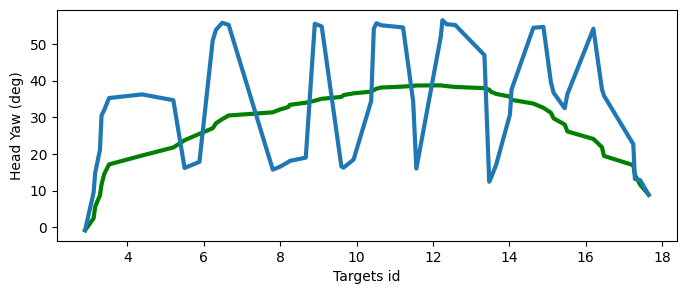

In [70]:
from sklearn.metrics import mean_squared_error
import pandas as pd
target_look_at_error_dict = {}
experiment_names = ["random_condition"]
nnn = 0
for id_i in range(1, 2):
    input_dir = input_dirs[id_i]
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    fileName = experiment_names[nnn]
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    min_length_head_and_eye = int(np.minimum(eye_trajectory.shape[0], head_trajectory.shape[0]))
    eye_trajectory = eye_trajectory[:min_length_head_and_eye]
    head_trajectory = head_trajectory[:min_length_head_and_eye]


    # input_json_0 = ExperimentData(eye_trajectory=eye_trajectory, head_trajectory=head_trajectory, target_trajectory=target_trajectory, input_target_times=target_input["duration"], input_target_angle=target_input["angle"])
    input_json_0 = {"eye_trajectory": eye_trajectory, "head_trajectory": head_trajectory, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
    internal_model_0 = InternalModelFromCapture(input_json_0)
    sequence_0 = []
    for i in range(0, len(input_json_0["input_target_angle"])):
        sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
    sequence_0 = np.array(sequence_0).T
    input_json = input_json_0
    input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
    input_sequence = np.array(input_sequence)
    input_sequence = input_sequence[:, 5:60]
from Signal_processing_utils import laplacian_smoothing

# make the plot wide
plt.figure(figsize=(8, 3))
# make the line thicker
plt.plot(input_sequence[0], laplacian_smoothing(input_sequence[1], 100), label="cccc\no", color="green", linewidth=3)
plt.plot(input_sequence[0], input_sequence[1], label="oooo\no", linewidth=2)
# legend is on top left
# plt.legend(loc="upper left")
plt.ylabel("Head Yaw (deg)")
plt.xlabel("Targets id")
plt.show()
